In [239]:
!pip  install transformers==4.22.1 -q

In [240]:
import transformers

In [241]:
!pip install tensorflow_probability==0.13.0

In [242]:
!pip install -U tensorflow==2.10

In [243]:
## for data
import json
import pandas as pd
import numpy as np
from sklearn import metrics, manifold
from tqdm import tqdm

## for processing
import re
import nltk

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for w2v
import gensim
import gensim.downloader as gensim_api

## for BERT
import transformers
import os

In [244]:
import tensorflow as tf
print(tf.__version__)

2.10.0


In [245]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_gpu_available())
print(tf.test.is_built_with_cuda())

[]
False
True


In [246]:
root_path = 'usersdata.csv'

In [247]:
df = pd.read_csv(root_path)
df.head()

,category,description
0,architect,Dipingo e progetto luoghi Emiliana introversa ...
1,manufacturer,En Chemifloor fabricamos resinas desde hace 30...
2,applicator,Le damos vida a tus espacios. Pintamos espacio...
3,architect,Quartz and marble decking solutions for archit...
4,applicator,Pintura Microcemento Molduras Papel Pintado ...


In [248]:
print(f'El conjunto de datos contiene un total de {len(df)} biografías.')

El conjunto de datos contiene un total de 434 biografías.


In [249]:
print(f'Hay un total de {len(set(df.category))} categorías en el conjunto de datos')
print(set(df.category))

Hay un total de 5 categorías en el conjunto de datos
{'applicator', 'architect', 'distributor', 'manufacturer', 'influencer'}


In [250]:
## Filtrar por categorías
df = df[ df["category"].isin(['applicator'])]
## print 5 random rows
df.sample(5)

,category,description
366,applicator,Microcimento #Revestimento e #Acabamento para ...
192,applicator,Pool & Spa Micro Bathrooms & Wet Areas Commer...
165,applicator,Aplicación de microcemento revocos de cal au...
4,applicator,Pintura Microcemento Molduras Papel Pintado ...
372,applicator,Treballs de pintura i estucs |||| Microciment ...


In [251]:
print(f'El conjunto de datos de muestra contiene {len(df)} biografías relacionadas con las categorías seleccionadas. {set(df.category)}')

El conjunto de datos de muestra contiene 68 biografías relacionadas con las categorías seleccionadas. {'applicator'}


# Unsupervised classification principles and approach

*   Clean data and embed it into the vector space.
*   Create a topic cluster for each category and embed it into the vector space.
*   Calculate similarities between every text vector and the topic clusters, then assign it to the closest cluster.




# Text preprocessing

*   Remove punctuation, convert to lower case.
*   Tokenize text to words.
*   Remove stopwords (nltk).
*   Stemming and lemmatisation.

In [252]:
def preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    '''
    Preprocess a string.
    :parameter
        :param text: string - name of column containing text
        :param lst_stopwords: list - list of stopwords to remove
        :param flg_stemm: bool - whether stemming is to be applied
        :param flg_lemm: bool - whether lemmitisation is to be applied
    :return
        cleaned text
    '''

    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())

    ## Tokenize (convert from string to list)
    lst_text = text.split()

    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]

    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]

    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]

    ## back to string from list
    text = " ".join(lst_text)
    return text

In [253]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    |   Package bcp47 is already up-to-dat

True

In [254]:
lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [255]:
df["text_clean"] = df["description"].apply(lambda x: preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))
df.head()

,category,description,text_clean
2,applicator,Le damos vida a tus espacios. Pintamos espacio...,le damos vida tus espacios pintamos espacios e...
4,applicator,Pintura Microcemento Molduras Papel Pintado ...,pintura microcemento molduras papel pintado ef...
15,applicator,Empresa Familiar Más de 40 años Pintamos Mo...,empresa familiar más de 40 años pintamos momen...
34,applicator,Hotline +1 814 3008251 Venetian plastering a...,hotline 1 814 3008251 venetian plastering acce...
40,applicator,Pitture per interni ed esterni • Resine • Micr...,pitture per interni ed esterni resine microcem...


# Create Target Clusters

Load gensim GloVe word embeddings

In [256]:
nlp = gensim_api.load("glove-wiki-gigaword-300")

In [257]:
# The gensim package has a very convenient function that returns the most similar words for any given word into the vocabulary
nlp.most_similar(["applicator"], topn=5)

[('applicators', 0.4341956675052643),
 ('sprayer', 0.4168723523616791),
 ('pressure-sensitive', 0.39669716358184814),
 ('zabaglione', 0.3942999541759491),
 ('dildo', 0.38730332255363464)]

In [258]:
# The gensim package has a very convenient function that returns the most similar words for any given word into the vocabulary
nlp.most_similar(["architect"], topn=5)

[('architects', 0.6924216747283936),
 ('sculptor', 0.6161724328994751),
 ('architectural', 0.5512393712997437),
 ('architecture', 0.5408962965011597),
 ('designed', 0.5389615893363953)]

In [259]:
# The gensim package has a very convenient function that returns the most similar words for any given word into the vocabulary
nlp.most_similar(["distributor"], topn=5)

[('distributors', 0.6703835129737854),
 ('wholesaler', 0.6256373524665833),
 ('supplier', 0.5923973917961121),
 ('manufacturer', 0.5860058665275574),
 ('importer', 0.5746791958808899)]

In [260]:
# The gensim package has a very convenient function that returns the most similar words for any given word into the vocabulary
nlp.most_similar(["manufacturer"], topn=5)

[('maker', 0.7996602654457092),
 ('manufacturers', 0.6734965443611145),
 ('manufactured', 0.6644791960716248),
 ('supplier', 0.6449663639068604),
 ('makers', 0.6203587055206299)]

In [261]:
# The gensim package has a very convenient function that returns the most similar words for any given word into the vocabulary
nlp.most_similar(["influencer"], topn=5)

[('influencers', 0.4158132076263428),
 ('eduniversal', 0.405753493309021),
 ('fast-track', 0.38926947116851807),
 ('eurofest', 0.3859441876411438),
 ('inape', 0.381629079580307)]

In [262]:
def get_similar_words(lst_words, top, nlp):
    lst_out = lst_words
    for tupla in nlp.most_similar(lst_words, topn=top):
        lst_out.append(tupla[0])
    return list(set(lst_out))

In [263]:
## Create Dictionary {category:[keywords]}
dic_clusters = {}
dic_clusters["applicator"] = get_similar_words(['designs','designed','architecture','architectural','designing'], top=30, nlp=nlp)
dic_clusters["architect"] = get_similar_words(['architects','sculptor','architectural','architecture','designed'], top=30, nlp=nlp)
dic_clusters["distributor"] = get_similar_words(['distributors','wholesaler','supplier','manufacturer','importer'], top=30, nlp=nlp)
dic_clusters["manufacturer"] = get_similar_words(['maker','manufacturers','manufactured','supplier','makers'], top=30, nlp=nlp)
dic_clusters["influencer"] = get_similar_words(['influencers','eduniversal','fast-track','eurofest','inape'], top=30, nlp=nlp)

In [264]:
## print top 5 closest words
print('Top words per label:')
for k,v in dic_clusters.items():
    print("{0:15}..... {1}".format(k, v[0:5], len(v)))

Top words per label:
applicator     ..... ['modern', 'developed', 'features', 'art', 'drawings']
architect      ..... ['art', 'renaissance', 'drawings', 'painter', 'artist']
distributor    ..... ['wholesalers', 'wholesale', 'manufacturer', 'makers', 'buyer']
manufacturer   ..... ['electronics', 'factory', 'machinery', 'equipment', 'manufacturer']
influencer     ..... ['agelena', 'plagiobothrys', 'phrynobatrachus', 'influencers', 'sparganothis']


# Visualize the selected topics with keyword clusters

<ipython-input-265-dfa81cf855a5>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dtf_GloVe = dtf_GloVe.append(dtf_group)
<ipython-input-265-dfa81cf855a5>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dtf_GloVe = dtf_GloVe.append(dtf_group)
<ipython-input-265-dfa81cf855a5>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dtf_GloVe = dtf_GloVe.append(dtf_group)
<ipython-input-265-dfa81cf855a5>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dtf_GloVe = dtf_GloVe.append(dtf_group)
<ipython-input-265-dfa81cf855a5>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use panda

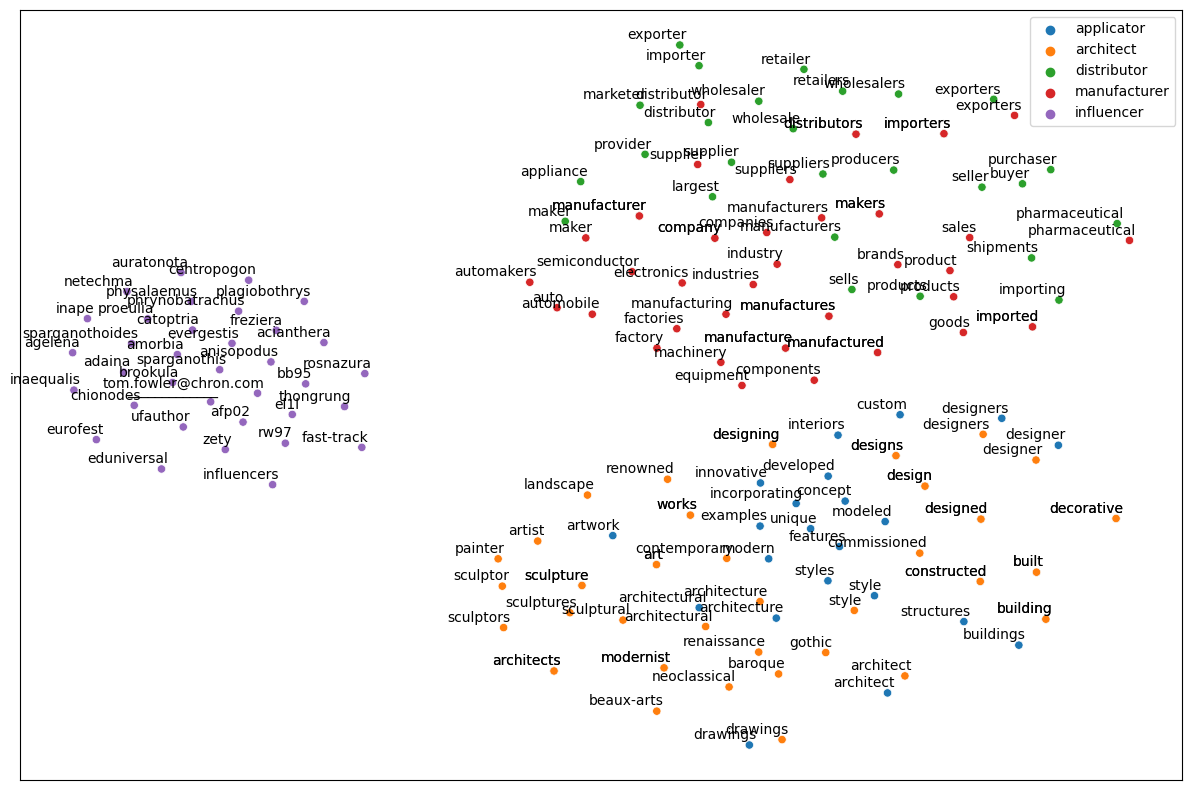

In [265]:
## word embedding
tot_words = [word for v in dic_clusters.values() for word in v]
X = nlp[tot_words]

## pca
pca = manifold.TSNE(perplexity=40, n_components=2, init='pca')
X = pca.fit_transform(X)

## create dtf
dtf_GloVe = pd.DataFrame()
for k,v in dic_clusters.items():
    size = len(dtf_GloVe) + len(v)
    dtf_group = pd.DataFrame(X[len(dtf_GloVe):size], columns=["x","y"], index=v)
    dtf_group["cluster"] = k
    dtf_GloVe = dtf_GloVe.append(dtf_group)

## plot
%matplotlib inline
fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(data=dtf_GloVe, x="x", y="y", hue="cluster", ax=ax)
#ax.legend().texts[0].set_text(None)
ax.legend()
ax.set(xlabel=None, ylabel=None, xticks=[], xticklabels=[], yticks=[], yticklabels=[])
for i in range(len(dtf_GloVe)):
    ax.annotate(dtf_GloVe.index[i], xy=(dtf_GloVe["x"].iloc[i], dtf_GloVe["y"].iloc[i]), xytext=(5,2), textcoords='offset points', ha='right', va='bottom')

# Load Transformers BERT model to create embeddings

In [266]:
## for BERT
import transformers
## bert tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
## bert model
nlp = transformers.TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


*   create average embeddings of sentence
*   Use BERT Word Embedding to represent each text with an array (shape: number of tokens x 768) and then summarize each article into a mean vector

In [267]:
## function to apply
def utils_bert_embedding(txt, tokenizer, nlp):
    '''
    Word embedding with Bert (equivalent to nlp["word"]).
    :parameter
        :param txt: string
        :param tokenizer: transformers tokenizer
        :param nlp: transformers bert
    :return
        tensor sentences x words x vector (1x3x768)
    '''
    # tokenize sentence to tokens (integers)
    idx = tokenizer.encode(txt)
    # convert to array of shape (1, num_words+2) - EOS and CLS added
    idx = np.array(idx)[None,:]
    # generate embeddings for each token - output is a tuple
    embedding = nlp(idx)
    # select first member of the tuple, remove first dimension which is 1 to get (num_words,embedding size 712)
    # exclude CLS and EOS tokens
    X = np.array(embedding[0][0][1:-1])
    return X

In [268]:
%%time
## create list of news vector
lst_mean_vecs = [utils_bert_embedding(txt, tokenizer, nlp).mean(0) for txt in tqdm(df["text_clean"])]

100%|██████████| 68/68 [00:48<00:00,  1.39it/s]

CPU times: user 41 s, sys: 885 ms, total: 41.9 s
Wall time: 48.9 s


In [269]:
## create the feature matrix (n news x 768)
X = np.array(lst_mean_vecs)
X.shape

(68, 768)

In [270]:
X

array([[ 0.26890382,  0.4050604 ,  0.44560096, ..., -0.5525286 ,
         0.14097811,  0.20034094],
       [ 0.15175551,  0.04277207,  0.4933241 , ..., -0.17389506,
        -0.04421312,  0.2031419 ],
       [-0.28739893,  0.25987354,  0.37447286, ..., -0.52875483,
         0.03847158,  0.23451228],
       ...,
       [ 0.4354916 ,  0.21118507,  0.19250216, ...,  0.25014094,
        -0.3391903 ,  0.1881599 ],
       [-0.04000341,  0.10711654,  0.14605309, ..., -0.16673313,
        -0.0915781 ,  0.36036044],
       [ 0.33495605,  0.3276221 ,  0.23494945, ..., -0.31257156,
        -0.5510606 , -0.06461672]], dtype=float32)

*   Do the same with the keywords in the target clusters. Each label is identified by a list of words that help BERT to understand the context within the clusters


In [271]:
# Create y as {label:mean_vector}
dic_y = {k:utils_bert_embedding(v, tokenizer, nlp).mean(0) for k,v in tqdm(dic_clusters.items())}

100%|██████████| 5/5 [00:02<00:00,  2.43it/s]


In [272]:
dic_clusters['applicator']

['modern',
 'developed',
 'features',
 'art',
 'drawings',
 'architecture',
 'decorative',
 'designer',
 'works',
 'built',
 'designing',
 'artwork',
 'modeled',
 'concept',
 'incorporating',
 'buildings',
 'designs',
 'design',
 'interiors',
 'unique',
 'style',
 'structures',
 'sculpture',
 'designed',
 'modernist',
 'building',
 'innovative',
 'styles',
 'architects',
 'constructed',
 'custom',
 'designers',
 'architectural',
 'architect',
 'examples']

In [273]:
dic_y['applicator'].shape

(768,)

In [274]:
dic_y['applicator']

array([ 7.30780780e-01,  8.25625181e-01,  5.37744880e-01, -1.77965522e-01,
        1.58055425e-01,  1.71878949e-01,  1.34821996e-01, -3.13537806e-01,
       -4.35878158e-01, -5.70033729e-01,  1.37205824e-01, -1.79316044e-01,
       -1.89744607e-02,  6.26327157e-01, -2.77891994e-01,  5.95775723e-01,
       -1.79618493e-01, -1.84037134e-01, -6.00441456e-01,  6.96992099e-01,
       -1.84140146e-01, -2.74694920e-01,  1.18395709e-01, -1.60324842e-01,
        2.09490713e-02, -3.38624239e-01,  9.54016671e-02,  1.91462450e-02,
       -1.04624569e-01,  6.49172515e-02,  5.06997049e-01, -4.06196825e-02,
       -2.10629869e-03, -2.27739632e-01, -2.14284167e-01, -1.59267351e-01,
       -9.63897351e-03, -3.98316860e-01, -2.13797748e-01, -1.23210758e-01,
       -4.45545405e-01, -5.76391339e-01,  8.09345424e-01, -2.52821207e-01,
       -1.42458424e-01, -5.39445043e-01, -1.46786287e-01,  2.16488913e-01,
       -3.51936936e-01, -1.35044202e-01, -2.15255588e-01,  1.13440283e-01,
        3.17303121e-01, -

# Model design & predict text classification

In [275]:
import numpy as np

def fix_NAN_inf_values(x):
    '''Replace NaN with zero and infinity with large finite numbers'''
    if x is None:
        return np.zeros_like(x)
    if len(np.where(np.isnan(x))[0]) > 0 or len(np.where(np.isnan(x))[1]) > 0:
        return np.nan_to_num(x)
    return x

## compute cosine similarities
similarities = np.dot(fix_NAN_inf_values(X), fix_NAN_inf_values(np.array(list(dic_y.values()))).T)

## adjust and rescale
similarities_adjusted = np.where(similarities > 0, similarities, 0)  # assign zero if similarity is negative
similarities_rescaled = similarities_adjusted / np.sum(similarities_adjusted, axis=1, keepdims=True)  # rescale so they sum to 1

## classify the label with the highest similarity score
predicted_prob = similarities_rescaled
predicted = [list(dic_clusters.keys())[np.argmax(pred)] for pred in predicted_prob]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
              precision    recall  f1-score   support

  applicator       1.00      0.46      0.63        68
   architect       0.00      0.00      0.00         0
  influencer       0.00      0.00      0.00         0
manufacturer       0.00      0.00      0.00         0

    accuracy                           0.46        68
   macro avg       0.25      0.11      0.16        68
weighted avg       1.00      0.46      0.63        68



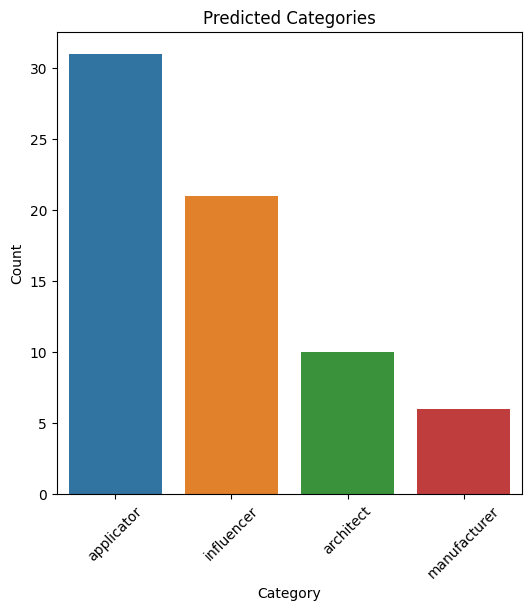

In [276]:
# Model evaluation

from sklearn.metrics import classification_report

true_labels = df["category"].tolist()

print("Classification Report:")
print(classification_report(true_labels, predicted))

# Visualize the classification results

df["predicted_category"] = predicted

## plot
plt.figure(figsize=(6, 6))
sns.countplot(data=df, x="predicted_category", order=df["predicted_category"].value_counts().index)
plt.title("Predicted Categories")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()
